## SAGA Paper 4, FIGURE 10:  Gas Phase Metallicity

In [1]:
import numpy as np
from myplotstyle import plt,get_figsize
%matplotlib inline

#from astropy import table
from astropy.table import Table
from astropy.io import ascii

from matplotlib import cm
#from matplotlib import colors
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.backends.backend_pdf
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.lines as mlines
#import matplotlib.patches as mpatches


from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

In [2]:
saga = SAGA.QuickStart()


SAGA `shared_dir` set to /Users/mg37/DropBox/SAGA/
SAGA `local_dir`  set to /Users/mg37/Projects/SAGA/


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

sats = C.is_sat.filter(base)

In [4]:
def calc_oh_metallicity(Ha, Ha_err, N2, N2_err):
    
    N2_index = np.log10(N2/Ha)

    marino_OH   = 8.743 + 0.462*N2_index
    
    logerr_ha = 0.434*Ha_err/Ha
    logerr_n2 = 0.434*N2_err/N2
    err_N2_index = np.sqrt(logerr_ha**2 + logerr_n2**2)

    OH_err = 0.462*err_N2_index
    
    # CALC SN
    SN_N2 = N2/N2_err
    SN_Ha = Ha/Ha_err

    
    return marino_OH, OH_err, SN_N2, SN_Ha

In [5]:
##  LMC/SMC
#
# Logsm (van der Marel 2006)
mw_mc_sm  = np.array([np.log10(2.7e9),np.log10(3.1e8)])

# SFR
mw_mc_sfr = np.array([np.log10(0.1),np.log10(0.037)])
mw_mc_ssfr = mw_mc_sfr-mw_mc_sm


#Direct method metallicity 
mw_mc_metal = np.array([8.36,8.1])

### READ SATELLITE LINE FLUXES

In [6]:
ekf = ascii.read('/Users/mg37/Projects/SAGA/SFR_external_cats/satellites_lines_df.csv')

ekf.add_column(0.,name='RA')
ekf.add_column(0.,name='DEC')
ekf.add_column(0.,name='log_sm')
ekf.add_column(0.,name='ssfr')
ekf.add_column(0.,name='ssfr_Ha')
ekf.add_column(-1.,name='EW_Halpha')
ekf.add_column(-1.,name='quenched')
ekf.add_column(0.,name='RHOST_KPC')
ekf.add_column(0.,name='SN_N2')

ekf.add_column(0.,name='log_MHI')
ekf.add_column('      ',name='TELNAME')


for i,obj in enumerate(ekf):
    m=sats['OBJID'] == obj['OBJID']

    if np.sum(m)>0:
        ekf['log_sm'][i] = sats['log_sm'][m]
        ekf['RA'][i] = sats['RA'][m]
        ekf['DEC'][i] = sats['DEC'][m]
        ekf['log_MHI'][i] = sats['log_MHI'][m]
        ekf['EW_Halpha'][i] = sats['EW_Halpha'][m]
        ekf['RHOST_KPC'][i] = sats['RHOST_KPC'][m]
        ekf['quenched'][i] = sats['quenched'][m]

        t = sats['TELNAME'][m]
        ekf['TELNAME'][i] = t[0]
        ekf['ssfr'][i]    = sats['nuv_sfr'][m] - sats['log_sm'][m] 
        ekf['ssfr_Ha'][i] = sats['Halpha_sfr'][m] - sats['log_sm'][m] 

  
# REMOVE QUENCHED GALAXIES AND THE 12 CLASSIFIED BASED ON NUV
m = (ekf['quenched'] == 0) & (ekf['EW_Halpha'] > 2)
sats_ekf=ekf[m]

In [7]:
# SATALLITE METALLICITIES

sats_OH, sats_OH_err, sats_SN_N2, sats_SN_Ha = calc_oh_metallicity(sats_ekf['F_Halpha_50'],sats_ekf['u_F_Halpha'], 
                                                      sats_ekf['F_[NII]6583_50'],sats_ekf['u_F_[NII]6583'])

snthresh=4
msn4_N2 =  (sats_SN_Ha > snthresh) & (sats_SN_N2 > snthresh) 

snthresh=3
msn3_N2 =  (sats_SN_Ha > snthresh) & (sats_SN_N2 > snthresh) 


/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66110/2184135260.py:3: RuntimeWarning: divide by zero encountered in log10
  N2_index = np.log10(N2/Ha)
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66110/2184135260.py:3: RuntimeWarning: invalid value encountered in log10
  N2_index = np.log10(N2/Ha)


In [8]:
mtel = (sats_ekf['TELNAME'] == 'AAT') | (sats_ekf['TELNAME'] == 'MMT') | \
       (sats_ekf['TELNAME'] == 'GAMA') | (sats_ekf['TELNAME'] == 'SDSS') | (sats_ekf['TELNAME'] == 'PAL')

mgood3 = msn3_N2&mtel
mgood4 = msn4_N2&mtel

print(np.sum(mgood3),np.sum(mgood4))

169 135


# SDSS DR8 JHU

In [9]:
x1 = Table.read('/Users/mg37/Projects/SAGA/SFR_external_cats/galSpecExtra-dr8.fits')
x2 = Table.read('/Users/mg37/Projects/SAGA/SFR_external_cats/galSpecInfo-dr8.fits')
x3 = Table.read('/Users/mg37/Projects/SAGA/SFR_external_cats/galSpecLine-dr8.fits')

In [10]:
sdss_OHerr = (x1['LGM_TOT_P84'] - x1['LGM_TOT_P16'])/2.
sdss_smerr = (x1['LGM_TOT_P84'] - x1['LGM_TOT_P16'])/2.


# CLEAN SDSS CATALOG BASED ON ERRORS AND SUGGESTED CUTS
err_metal = (x1['OH_P84'] - x1['OH_P16'])/2.
msdss= (x2['RELIABLE'] == 1) & \
       (x1['MJD'] > 0) & \
       (x1['LGM_TOT_P50']>0)  & \
       (x2['Z'] < 0.035) & (x2['Z'] > 0.007) &\
       (x2['Z_WARNING'] ==0)  &\
       (np.isfinite(sdss_smerr)) & (sdss_smerr < 0.2) &\
       (x1['BPTCLASS'] < 2) &\
       (err_metal > 0.0001) & (err_metal < 0.2) &\
       (x1['SFR_FIB_P50']-x1['LGM_TOT_P50'] > -11) &\
       (x3['H_ALPHA_FLUX'] < 1e4)


xx1=x1[msdss]
xx2=x2[msdss]
xx3=x3[msdss]

sdss_OH, sdss_OH_err, sdss_SN_N2, sdss_SN_Ha = calc_oh_metallicity(xx3['H_ALPHA_FLUX'],xx3['H_ALPHA_FLUX_ERR'], 
                                                      xx3['NII_6584_FLUX'],xx3['NII_6584_FLUX_ERR'])

sdss_logsm = xx1['LGM_TOT_P50'] + np.log10(1.08)  

                                              
snthresh  = 4
msdss_SN  = (sdss_SN_N2 > snthresh) & (sdss_SN_Ha > snthresh) 

/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66110/2184135260.py:3: RuntimeWarning: invalid value encountered in true_divide
  N2_index = np.log10(N2/Ha)
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66110/2184135260.py:7: RuntimeWarning: divide by zero encountered in true_divide
  logerr_ha = 0.434*Ha_err/Ha
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66110/2184135260.py:8: RuntimeWarning: divide by zero encountered in true_divide
  logerr_n2 = 0.434*N2_err/N2


In [11]:
# REMOVE SHREDDED SDSS GALAXIES!
x = np.arange(6.5,10)
y = 0.2*x + 6.77

ythresh = 0.2*sdss_logsm + 6.77
m1 = (ythresh < sdss_OH) 
m2 = (xx2['Z'] > 0.015) | (sdss_SN_N2 >  50)
mshred = m1&m2


In [12]:
sdss_OH    = sdss_OH[msdss_SN&~mshred]
sdss_logsm = sdss_logsm[msdss_SN&~mshred]

### SDSS RUNNING MEDIAN

In [13]:
# running median
sm      = np.arange(7.8,10.3,0.1)
rm_sdss_OH_50  = np.zeros(np.size(sm))
rm_sdss_OH_16  = np.zeros(np.size(sm))
rm_sdss_OH_84  = np.zeros(np.size(sm))

for i,s in enumerate(sm):
    m = (sdss_logsm > s-0.05) & (sdss_logsm < s+0.05)
    rm_sdss_OH_16[i],rm_sdss_OH_50[i],rm_sdss_OH_84[i] =  np.percentile(sdss_OH[m],[16,50,84])

#    print((rm_sdss_OH_16[i] - rm_sdss_OH_84[i])/2.)
    
print('Median scatter:',np.median(rm_sdss_OH_84 - rm_sdss_OH_16)/2.) 

Median scatter: 0.06061124801635742


In [14]:
def bin_median(bins,x,y,yerr, ssfr):
    
    wmedian,werr1, werr2 = [],[],[]
    
    diff_sfr = []
    
    print('log_sm   upp  low  combined    sSFR_siff')
    for i,b in enumerate(bins[:-1]):
        m = (x>bins[i]) & (x<bins[i+1])
        xx = np.percentile(y[m], [16, 50, 84]) 
        
        wmedian.append(xx[1])
        werr1.append(xx[1] - xx[0])
        werr2.append(xx[2] - xx[1])
        
        # OBJECT BELOW AND ABOVE MEDIAN
        m_high = y[m] > xx[1]
        m_low  = y[m] < xx[1]
      
        bin_ssfr= ssfr[m]
        sf_high = np.nanmean(bin_ssfr[m_high])
        sf_low = np.nanmean(bin_ssfr[m_low])
        sf_high = np.nanmedian(bin_ssfr[m_high])
        sf_low = np.nanmedian(bin_ssfr[m_low])

        print('{:0.2f}  {:0.2f} {:0.2f}  {:0.2f}  {:0.2f}'.format(b, xx[1] - xx[0], xx[2] - xx[1],\
                                                                  (xx[2] - xx[0])/2., sf_low-sf_high))
        
    return wmedian,werr1,werr2

In [15]:
#pbins = np.linspace(0, 100, 5)
#log_sm = np.concatenate([sats_ekf['log_sm']])
#log_sm = log_sm[log_sm >= 6.75]
#bins = np.percentile(log_sm, pbins)
#x = np.percentile(log_sm, (pbins[1:]+pbins[:-1])*0.5)

# SET BINS
x    = [7,7.5,8,8.5,9,9.5]
bins = [6.75,7.25,7.75,8.25,8.75,9.25,9.75]

a,b,c = bin_median(bins,sats_ekf['log_sm'][mgood4],sats_OH[mgood4],sats_OH_err[mgood4],sats_ekf['ssfr'][mgood4])


log_sm   upp  low  combined    sSFR_siff
6.75  0.21 0.17  0.19  0.38
7.25  0.09 0.18  0.13  0.33
7.75  0.11 0.13  0.12  0.45
8.25  0.09 0.13  0.11  0.54
8.75  0.09 0.05  0.07  0.23
9.25  0.04 0.05  0.05  0.58


/Users/mg37/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


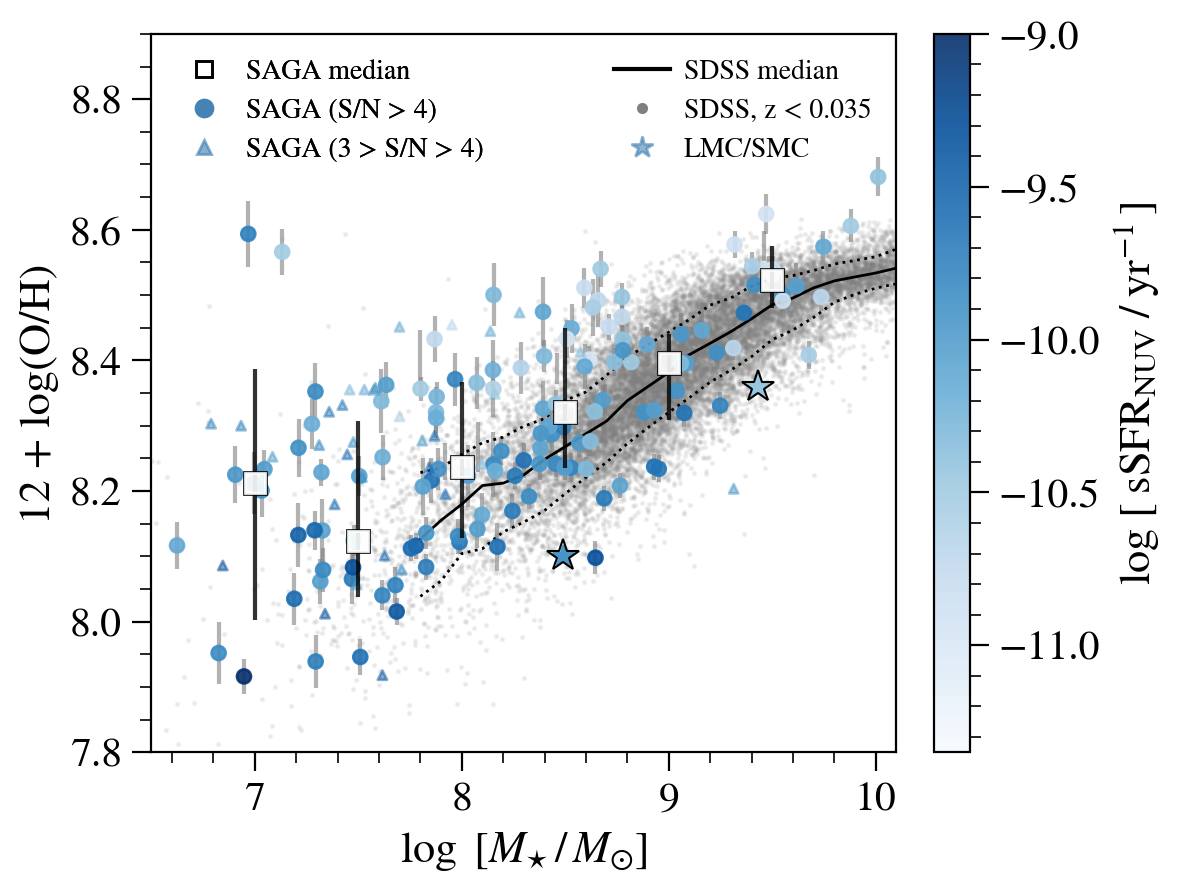

In [16]:
pdf = matplotlib.backends.backend_pdf.PdfPages('figure_metallicity.pdf')
fig, (ax1) = plt.subplots(ncols=1, figsize=get_figsize(wide=False, ratio=1.35))



from matplotlib.colors import LinearSegmentedColormap
# Define the original colormap
original_cmap = plt.cm.Blues
# Define the truncation point (where you want to chop the colormap)
truncate_point = 0.25
# Create a new truncated colormap
new_colors = original_cmap(np.linspace(truncate_point, 1, 256))
new_cmap = LinearSegmentedColormap.from_list("truncated_cmap", new_colors)


cm = ax1.scatter(sats_ekf['log_sm'][mgood4],sats_OH[mgood4],c = sats_ekf['ssfr'][mgood4],alpha=0.9,\
                 vmin=-11.35,vmax=-9.,cmap='Blues',zorder=3)

ax1.scatter(sats_ekf['log_sm'][mgood3&~mgood4],sats_OH[mgood3&~mgood4],c = sats_ekf['ssfr'][mgood3&~mgood4],\
            marker='^',alpha=0.5,vmin=-11.35,vmax=-9,cmap='Blues',zorder=3,s=11)


# MEDIAN BINS
color='k'
ax1.plot(x,a,'s',c='white',ms=7,alpha=0.9,zorder=10)
ax1.errorbar(x,a,yerr=[b,c],ls='none',c='k',ms=8,alpha=0.8,lw=1.5,zorder=5)
ax1.plot(x,a,'s',c='k',ms=8,alpha=0.9,mfc='none',zorder=5)

plt.colorbar(cm,label=r'$\log \, [ \; {\rm sSFR}_{\rm NUV} \; / \; {\rm yr}^{-1}\,$]')

       
ax1.errorbar(sats_ekf['log_sm'][mgood4],sats_OH[mgood4],fmt='None',yerr=sats_OH_err[mgood4],\
             c='grey',alpha=0.6,zorder=1)

ax1.scatter(sdss_logsm,sdss_OH, c='grey',alpha=0.1,zorder=-1,s=1,rasterized=True)


ax1.set_xlabel('$\log~[M_{\star}\,/\,M_{\odot}]$')
ax1.set_ylabel('12 + log(O/H)')
ax1.legend()




# DATA LEGEND
msdss = mlines.Line2D([], [], color='k', ls='-', label='SDSS median')
lsdss = mlines.Line2D([], [], color='grey', marker='o', ls='', label='SDSS, z < 0.035',ms=3)
sgbg = mlines.Line2D([], [], color='grey', marker='o', ls='', label='SAGAbg, z < 0.035',ms=7)


l1 = mlines.Line2D([], [], color='steelblue', marker='o', ls='', label='SAGA (S/N > 4)',ms=6)
l2 = mlines.Line2D([], [], color='steelblue', marker='^', ls='', label='SAGA (3 > S/N > 4)',ms=5,alpha=0.4)

l3 = mlines.Line2D([], [], color='k', mfc='none',marker='s', ls='', label='SAGA median',ms=6,alpha=0.9)
lc = mlines.Line2D([], [], color='steelblue', marker='*', ls='', label='LMC/SMC',ms=8,alpha=0.6)


leg2 = ax1.legend(fontsize=10,loc='upper right',handles=[msdss,lsdss,lc])
leg3 = ax1.legend(fontsize=10,loc='upper left',handles=[l3,l1,l2])

ax1.add_artist(leg2)
ax1.add_artist(leg3)


ax1.set_xlim(6.5,10.1)
ax1.set_ylim(7.8,8.9)


ax1.plot(sm,rm_sdss_OH_50,'k',alpha=1,lw=1)
ax1.plot(sm,rm_sdss_OH_16,'k',ls=':',alpha=1,lw=1)
ax1.plot(sm,rm_sdss_OH_84,'k',ls=':',alpha=1,lw=1)

# PLOT MC points
s1=55
s2=12
ax1.scatter(mw_mc_sm,mw_mc_metal,c=mw_mc_ssfr,marker='*',vmin=-11.35,vmax=-9.,\
            s=s1,cmap='Blues')
ax1.plot(mw_mc_sm,mw_mc_metal,'*k',ms=s2,mfc='None',markeredgewidth=0.75)




pdf.savefig()
pdf.close()